In [4]:
import os 
import s3fs
import metpy
import numpy as np
import pandas as pd
import xarray as xr
import geoviews as gv
import geoviews.feature as gf
from geoviews import opts
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from netCDF4 import Dataset
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import dask
from dask.distributed import Client, LocalCluster, progress

In [2]:
cluster = LocalCluster(processes=False, local_directory='/tmp') 
client = Client(cluster) 
client

<Client: 'inproc://192.168.170.214/367/1' processes=1 threads=4, memory=8.59 GB>

## Load one goes file into memory to get metadata

In [5]:
goes_file = "s3://noaa-goes17/ABI-L2-FDCC/2018/317/12/OR_ABI-L2-FDCC-M3_G17_s20183171252219_e20183171254592_c20183171255130.nc"
fs = s3fs.S3FileSystem()
fh = fs.open(goes_file, "rb") 
data = fh.read()
ds = Dataset("memory", memory=data)
goes = xr.open_dataset(xr.backends.NetCDF4DataStore(ds))

## Transform x,y coordinates to regular latitude and longitude

In [6]:
def transform_xy_latlon(
    goes_subset: xr.Dataset, goes_proj: ccrs.Geostationary, sheight: float
) -> tuple:
    """
    Transform xy coordinates to latitudes and longitudes
    :param goes_subset: a subset(California) from goes data
    :param goes_proj: geostationary projection
    :param sheight: height of satellite
    :return: a tuple of lats/lons
    """
    # Transform goes xy coordinates to regular lats/lons
    latlon = ccrs.PlateCarree()
    goes_x, goes_y = np.meshgrid(goes_subset.x * sheight, goes_subset.y * sheight)
    goes_coords = latlon.transform_points(goes_proj, goes_x, goes_y)
    goes_lons = goes_coords[:, :, 0]
    goes_lats = goes_coords[:, :, 1]

    return goes_lats, goes_lons

## Determine coordinates so we can get a subset 

In [10]:
def xy_coord_zoom(data_proj: ccrs, in_coords: tuple):
    """
    Find x, y plane coordinates for slicing

    :param data_proj: data source projection
    :param in_coords: a tuple with domain coordinates x1, x2, y1, y2

    :return x, y plane zoomed coordinates
    """

    latlon = ccrs.PlateCarree()
    x1, x2, y1, y2 = in_coords
    lats = np.array([x1, x2])
    lons = np.array([y2, y1])
    out_coords = data_proj.transform_points(latlon, lons, lats)
    zoom = {'x': slice(out_coords[1][0], out_coords[0][0]), 'y': slice(out_coords[1][1], out_coords[0][1])}    
    zoom['x'] = slice(zoom['x'].start / sheight, zoom['x'].stop / sheight)
    zoom['y'] = slice(zoom['y'].start / sheight, zoom['y'].stop / sheight)

    return zoom

In [11]:
def get_goes17_data(year: int, jday: int) -> xr.Dataset:
    """
    Load GOES-17 ABI-L2-FDCC data

    :param year: 4 digit year
    :param jday: julian day

    :return xr.Dataset
    """
    
    files = f"s3://noaa-goes17/ABI-L2-FDCC/{year}/{jday}/*/OR_ABI-L2-FDCC-M3_G17_s{year}{jday}*000*.nc"
    file_location = fs.glob(files)
    
    #make a list of links to the file keys
    if len(file_location)<1:
        return None
    all_files = [fs.open(file) for file in file_location]
    
    #open all the data
    ds = xr.open_mfdataset(all_files,combine='nested',concat_dim='time') #note file is super messed up formatting
      
    return ds

## Get data projection and satellite height

In [12]:
mask= goes.metpy.parse_cf('Mask')
goes_proj = mask.metpy.cartopy_crs
sheight = ds['goes_imager_projection'].perspective_point_height

## Take a subset from center of Camp Fire 39.8134, -121.4347  
### 2 degrees in each direction and slice the data

In [14]:
in_coords = (37.7, 41.9, -123.5, -119.3)
zoom = xy_coord_zoom(goes_proj, in_coords)
subset = goes.sel(x=zoom['x'], y=zoom['y'])
subset

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, x: 206, y: 159)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1124 ... ...
  * x                                                 (x) float32 0.02937 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    sunglint_angle                                    float32 ...
    local_zenith_angle                                float32 ...
    solar_zenith_angle                                float32 ...
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds
Data variables:
    Area                                              (y, x) float32 ...
    Temp                                              (y, x) float32 ...
    Mask                                              (y, x) float32 ...
    Power                                             (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    float32 ...
    nominal_satellite_subpoint_lon                    float32 ...
    nominal_satellite_height                          float32 ...
    geospatial_lat_lon_extent                         float32 ...
    sunglint_angle_bounds                             (number_of_sunglint_angle_bounds) float32 ...
    local_zenith_angle_bounds                         (number_of_LZA_bounds) float32 ...
    solar_zenith_angle_bounds                         (number_of_SZA_bounds) float32 ...
    total_number_of_pixels_with_fires_detected        float64 ...
    total_number_of_pixels_with_fire_temperature      float64 ...
    total_number_of_pixels_with_fire_area             float64 ...
    total_number_of_pixels_with_fire_radiative_power  float64 ...
    fire_temperature_outlier_pixel_count              float64 ...
    fire_area_outlier_pixel_count                     float64 ...
    fire_radiative_power_outlier_pixel_count          float64 ...
    minimum_fire_temperature                          float32 ...
    maximum_fire_temperature                          float32 ...
    mean_fire_temperature                             float32 ...
    standard_deviation_fire_temperature               float32 ...
    minimum_fire_area                                 float32 ...
    maximum_fire_area                                 float32 ...
    mean_fire_area                                    float32 ...
    standard_deviation_fire_area                      float32 ...
    minimum_fire_radiative_power                      float32 ...
    maximum_fire_radiative_power                      float32 ...
    mean_fire_radiative_power                         float32 ...
    standard_deviation_fire_radiative_power           float32 ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    percent_uncorrectable_GRB_errors                  float32 ...
    percent_uncorrectable_L0_errors                   float32 ...
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Sta

## Convert goes xy coordinates to regular lat/lon

In [15]:
goes_lats, goes_lons = transform_xy_latlon(subset, goes_proj, sheight)
goes_lats,goes_lons

(array([[41.88338913, 41.88417013, 41.88495293, ..., 42.07765332,
         42.07879771, 42.0799442 ],
        [41.85463685, 41.85541649, 41.85619793, ..., 42.04855615,
         42.04969846, 42.05084287],
        [41.82590459, 41.82668287, 41.82746296, ..., 42.01947999,
         42.02062024, 42.02176258],
        ...,
        [37.6136873 , 37.61429427, 37.61490261, ..., 37.76397731,
         37.76485846, 37.76574117],
        [37.58756601, 37.58817206, 37.58877949, ..., 37.73762587,
         37.73850565, 37.73938699],
        [37.56145891, 37.56206404, 37.56267056, ..., 37.71128915,
         37.71216756, 37.71304753]]),
 array([[-123.50308273, -123.4764704 , -123.44984778, ..., -117.97225263,
         -117.94426489, -117.91626525],
        [-123.51013938, -123.48354211, -123.45693456, ..., -117.98261629,
         -117.95464634, -117.92666449],
        [-123.51718065, -123.4905984 , -123.46400588, ..., -117.99295649,
         -117.96500428, -117.9370402 ],
        ...,
        [-124.4452

### Now we have the projection, subset coordinates, and zoom levels we can read data in bulk

In [17]:
ds = get_goes17_data(2018, 318)
ds

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, time: 24, x: 2500, y: 1500)
Coordinates:
    t                                                 (time) datetime64[ns] 2...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.06997 .....
    y_image                                           float32 0.08624
    x_image                                           float32 0.0
    sunglint_angle                                    float32 10.0
    local_zenith_angle                                float32 80.0
    solar_zenith_angle                                float32 10.0
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds, time
Data variables:
    Area                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Temp                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Mask                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Power                                             (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    DQF                                               (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    time_bounds                                       (time, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                            (time) int32 -214748364...
    y_image_bounds                                    (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                                    (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_subpoint_lat                    (time) float64 0.0 ... 0.0
    nominal_satellite_subpoint_lon                    (time) float64 -137.2 ....
    nominal_satellite_height                          (time) float64 3.579e+0...
    geospatial_lat_lon_extent                         (time) float32 9.969e+3...
    sunglint_angle_bounds                             (time, number_of_sunglint_angle_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    local_zenith_angle_bounds                         (time, number_of_LZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    total_number_of_pixels_with_fires_detected        (time) float64 6.0 ... ...
    total_number_of_pixels_with_fire_temperature      (time) float64 0.0 ... 2.0
    total_number_of_pixels_with_fire_area             (time) float64 0.0 ... 2.0
    total_number_of_pixels_with_fire_radiative_power  (time) float64 6.0 ... 6.0
    fire_temperature_outlier_pixel_count              (time) float64 0.0 ... 0.0
    fire_area_outlier_pixel_count                     (time) float64 0.0 ... 1.0
    fire_radiative_power_outlier_pixel_count          (time) float64 5.0 ... 4.0
    minimum_fire_temperature                          (time) float64 nan ... ...
    maximum_fire_temperature                          (time) float64 nan ... ...
    mean_fire_temperature                             (time) float64 nan ... ...
    standard_deviation_fire_temperature               (time) float64 nan ... ...
    minimum_fire_area                                 (time) float64 nan ... ...
    maximum_fire_area                                 (time) float64 nan ... ...
    mean_fire_area                    

### Zoom into Camp Area

In [18]:
subset = ds.sel(x=zoom['x'], y=zoom['y'])
subset

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, time: 24, x: 206, y: 159)
Coordinates:
    t                                                 (time) datetime64[ns] 2...
  * y                                                 (y) float32 0.1124 ... ...
  * x                                                 (x) float32 0.02937 ......
    y_image                                           float32 0.08624
    x_image                                           float32 0.0
    sunglint_angle                                    float32 10.0
    local_zenith_angle                                float32 80.0
    solar_zenith_angle                                float32 10.0
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds, time
Data variables:
    Area                                              (time, y, x) float32 dask.array<chunksize=(1, 159, 206), meta=np.ndarray>
    Temp                                              (time, y, x) float32 dask.array<chunksize=(1, 159, 206), meta=np.ndarray>
    Mask                                              (time, y, x) float32 dask.array<chunksize=(1, 159, 206), meta=np.ndarray>
    Power                                             (time, y, x) float32 dask.array<chunksize=(1, 159, 206), meta=np.ndarray>
    DQF                                               (time, y, x) float32 dask.array<chunksize=(1, 159, 206), meta=np.ndarray>
    time_bounds                                       (time, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                            (time) int32 -214748364...
    y_image_bounds                                    (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                                    (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_subpoint_lat                    (time) float64 0.0 ... 0.0
    nominal_satellite_subpoint_lon                    (time) float64 -137.2 ....
    nominal_satellite_height                          (time) float64 3.579e+0...
    geospatial_lat_lon_extent                         (time) float32 9.969e+3...
    sunglint_angle_bounds                             (time, number_of_sunglint_angle_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    local_zenith_angle_bounds                         (time, number_of_LZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    total_number_of_pixels_with_fires_detected        (time) float64 6.0 ... ...
    total_number_of_pixels_with_fire_temperature      (time) float64 0.0 ... 2.0
    total_number_of_pixels_with_fire_area             (time) float64 0.0 ... 2.0
    total_number_of_pixels_with_fire_radiative_power  (time) float64 6.0 ... 6.0
    fire_temperature_outlier_pixel_count              (time) float64 0.0 ... 0.0
    fire_area_outlier_pixel_count                     (time) float64 0.0 ... 1.0
    fire_radiative_power_outlier_pixel_count          (time) float64 5.0 ... 4.0
    minimum_fire_temperature                          (time) float64 nan ... ...
    maximum_fire_temperature                          (time) float64 nan ... ...
    mean_fire_temperature                             (time) float64 nan ... ...
    standard_deviation_fire_temperature               (time) float64 nan ... ...
    minimum_fire_area                                 (time) float64 nan ... ...
    maximum_fire_area                                 (time) float64 nan ... ...
    mean_fire_area                                

### Temperatures are nans(not available) in this day so we are going to use Mask instead

In [19]:
mask = subset["Mask"]
mask

<xarray.DataArray 'Mask' (time: 24, y: 159, x: 206)>
dask.array<getitem, shape=(24, 159, 206), dtype=float32, chunksize=(1, 159, 206), chunktype=numpy.ndarray>
Coordinates:
    t                   (time) datetime64[ns] 2018-11-14T00:03:40.626225920 ....
  * y                   (y) float32 0.1124 0.1123 0.1123 ... 0.1036 0.1035
  * x                   (x) float32 0.02937 0.02943 0.02948 ... 0.0408 0.04085
    y_image             float32 0.08624
    x_image             float32 0.0
    sunglint_angle      float32 10.0
    local_zenith_angle  float32 80.0
    solar_zenith_angle  float32 10.0
Dimensions without coordinates: time
Attributes:
    long_name:                                                               ...
    valid_range:                                                             ...
    units:                                                                   ...
    resolution:                                                              ...
    grid_mapping:                                                            ...
    cell_methods:                                                            ...
    flag_values:                                                             ...
    flag_meanings:                                                           ...
    ancillary_variables:                                                     ...
    number_of_fire_categories:                                               ...
    percent_good_fire_pixel_or_temporally_filtered_good_fire_pixel:          ...
    percent_saturated_fire_pixel_or_temporally_filtered_saturated_fire_pixel:...
    percent_cloud_contaminated_fire_pixel_or_temporally_filtered_cloud_contam...
    percent_high_probability_fire_pixel_or_temporally_filtered_high_probabili...
    percent_medium_probability_fire_pixel_or_temporally_filtered_medium_proba...
    percent_low_probability_fire_pixel_or_temporally_filtered_low_probability...
    invalid_fire_MODIS_land_mask_types_definition:                           ...

### Save data into a new array with regular lat/lon coordinates and time

In [23]:
new_data = xr.DataArray(mask, coords={"time": mask.t.values, "latitude": (["x","y"], goes_lats),
                          "longitude": (["x","y"], goes_lons)}, dims=["time", "x","y"])
new_data

<xarray.DataArray 'Mask' (time: 24, x: 159, y: 206)>
array([[[240., 240., 240., ..., 240., 240., 240.],
        [240., 240., 240., ..., 240., 240., 240.],
        [240., 240., 240., ..., 240., 240., 240.],
        ...,
        [150., 150., 150., ..., 240., 240., 240.],
        [150., 150., 150., ..., 240., 240., 240.],
        [150., 150., 150., ..., 240., 240., 240.]],

       [[240., 240., 240., ..., 240., 240., 240.],
        [240., 240., 240., ..., 240., 240., 240.],
        [240., 240., 240., ..., 240., 240., 240.],
        ...,
        [150., 150., 150., ..., 240., 240., 240.],
        [150., 150., 150., ..., 240., 240., 240.],
        [150., 150., 150., ..., 240., 240., 240.]],

       [[240., 240., 240., ..., 240., 240., 240.],
        [240., 240., 240., ..., 240., 240., 240.],
        [240., 240., 240., ..., 240., 240., 240.],
        ...,
...
        ...,
        [150., 150., 150., ..., 100., 245., 245.],
        [150., 150., 150., ..., 100., 100., 245.],
        [150., 150., 150., ..., 100., 100., 100.]],

       [[240., 240., 240., ..., 245., 245., 245.],
        [240., 240., 240., ..., 245., 245., 245.],
        [100., 240., 240., ..., 245., 245., 170.],
        ...,
        [150., 150., 150., ..., 100., 245., 245.],
        [150., 150., 150., ..., 100., 100., 100.],
        [150., 150., 150., ..., 100., 100., 100.]],

       [[240., 240., 240., ..., 245., 245., 245.],
        [240., 240., 240., ..., 245., 170., 245.],
        [240., 240., 240., ..., 245., 170., 170.],
        ...,
        [150., 150., 150., ..., 100., 245., 245.],
        [150., 150., 150., ..., 100., 100., 100.],
        [150., 150., 150., ..., 240., 240., 240.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2018-11-14T00:03:40.626225920 ... 2018-1...
    latitude   (x, y) float64 41.88 41.88 41.88 41.89 ... 37.71 37.71 37.71
    longitude  (x, y) float64 -123.5 -123.5 -123.4 ... -119.4 -119.3 -119.3
Dimensions without coordinates: x, y
Attributes:
    long_name:                                                               ...
    valid_range:                                                             ...
    units:                                                                   ...
    resolution:                                                              ...
    grid_mapping:                                                            ...
    cell_methods:                                                            ...
    flag_values:                                                             ...
    flag_meanings:                                                           ...
    ancillary_variables:                                                     ...
    number_of_fire_categories:                                               ...
    percent_good_fire_pixel_or_temporally_filtered_good_fire_pixel:          ...
    percent_saturated_fire_pixel_or_temporally_filtered_saturated_fire_pixel:...
    percent_cloud_contaminated_fire_pixel_or_temporally_filtered_cloud_contam...
    percent_high_probability_fire_pixel_or_temporally_filtered_high_probabili...
    percent_medium_probability_fire_pixel_or_temporally_filtered_medium_proba...
    percent_low_probability_fire_pixel_or_temporally_filtered_low_probability...
    invalid_fire_MODIS_land_mask_types_definition:                           ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
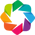

In [25]:
gv.extension('bokeh', 'matplotlib')

opts.defaults(
    opts.Image(width=600, height=400, colorbar=True),
    opts.Feature(apply_ranges=False),
    opts.QuadMesh(width=600, height=400, colorbar=True))


In [26]:
opts.defaults(opts.Image(cmap='RdBu_r'), opts.QuadMesh(cmap='RdBu_r'))
gvds = gv.Dataset(new_data)
quadmeshes = gvds.to(gv.QuadMesh, ['longitude', 'latitude'], dynamic=True)
quadmeshes.apply(lambda x: x.clone(x.data.Mask[::2, ::2])) * gv.feature.coastline


/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


:DynamicMap   [time]
   :Overlay
      .QuadMesh.I  :QuadMesh   [longitude,latitude]   (Mask)
      .Coastline.I :Feature   [Longitude,Latitude]